# Code for Section 3.5 Better Backtesting

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import fortitudo.tech as ft
import matplotlib.pyplot as plt

# Download and preprocess data

In [8]:
tickers = [
    'XLB', 'XLE', 'XLF', 'XLI', 'XLK',
    'XLP', 'XLU', 'XLV', 'XLY', '^GSPC', '^VIX']  # add VIX for the state variable
data = yf.download(tickers, start='1998-12-22', end='2024-10-12')['Adj Close']

names_dict = {
    'XLB': 'Materials', 'XLE': 'Energy', 'XLF': 'Financial', 'XLI': 'Industrial',
    'XLK': 'Technology', 'XLP': 'Consumer Staples', 'XLU': 'Utilities',
    'XLV': 'Health Care', 'XLY': 'Consumer Discretionary', '^GSPC': 'S&P 500', '^VIX': 'VIX'}
data = data.rename(columns=names_dict)

T = len(data)
print(f'The number of daily observations is {T}.')

[*********************100%%**********************]  11 of 11 completed

The number of daily observations is 6493.


In [ ]:
H = 63
equity_returns = (data.values[H:, :-1] - data.values[0:-H, :-1]) / data.iloc[0:-H, :-1]
equity_returns_df = pd.DataFrame(100 * equity_returns, columns=data.columns[:-1])
equity_stats = ft.simulation_moments(equity_returns_df)
cvars = ft.portfolio_cvar(
    np.eye(len(equity_returns_df.columns)), equity_returns_df, alpha=0.9)
equity_stats['90%-CVaR'] = cvars[0, :]
display(np.round(equity_stats, 2))

,Mean,Volatility,Skewness,Kurtosis,90%-CVaR
Ticker,,,,,
Materials,2.50,9.92,-0.48,5.99,18.89
Energy,2.79,12.38,-0.22,5.35,22.66
Financial,1.98,11.45,-0.07,9.35,22.41
Industrial,2.54,9.27,-0.62,5.77,18.62
Technology,2.73,11.01,-0.62,4.24,22.76
Consumer Staples,1.85,5.81,-0.59,4.49,11.61
Utilities,2.12,7.61,-0.62,4.80,15.10
Health Care,2.31,6.79,-0.58,4.22,13.15
Consumer Discretionary,2.65,9.45,-0.29,5.08,18.20


# Compute daily log returns as the stationary transformations

In [16]:
stationary_transformations = np.diff(np.log(data.iloc[:, :-1]), axis=0)
state_variable = data['VIX'].iloc[1:].values

# Fully Flexible Resampling functions from Section 3.2.1
Below are some helper functions for the market simulation using Fully Flexible Resampling. These will be useful in the backtesting loop below.

In [60]:
def conditioning_bands(state_variable):
    value_low = np.percentile(state_variable, 25)
    indices_low = state_variable <= value_low
    value_high = np.percentile(state_variable, 75)
    indices_mid = (state_variable < value_low) ^ (state_variable <= value_high)
    indices_high = state_variable > value_high
    return indices_low, indices_mid, indices_high

def compute_states_vector(indices_low, indices_mid, indices_high):
    return 0 * indices_low + 1 * indices_mid + 2 * indices_high

def conditioning_views(indices, state_variable):
    mu = np.mean(state_variable[indices])
    sigma = np.std(state_variable[indices])
    return mu, sigma

def conditioning_rhs(mu, sigma):
    b = np.array(([[1.], [mu]]))
    h = np.array([[sigma ** 2 + mu ** 2]])
    return b, h

def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim, current_state

# Backtest

In [ ]:
H = 63  # Simulation horizon
S = 100  # Number of synthetic paths
S_oos_synth = 100  # Number of synthetic out-of-sample paths

out_of_sample_years = 15
out_of_sample_obs = out_of_sample_years * 252
out_of_sample_quarters = out_of_sample_years * 4

# Set long-only constraints and preallocate space for results
I = len(tickers) - 1
G = -np.eye(I)
h = np.zeros(I)

np.random.seed(0)  # for replicability

In [ ]:
cvar_results = np.full((I, out_of_sample_quarters), np.nan)
variance_results = np.full((I, out_of_sample_quarters), np.nan)
oos_synth_paths = np.full((S_oos_synth, out_of_sample_obs, I), np.nan)

indices_synth_init = conditioning_bands(state_variable[:-out_of_sample_obs])
states_vector = compute_states_vector(*indices_synth_init)
oos_synth_states = np.full((S_oos_synth), states_vector[-1], dtype=np.int8)

for q in np.arange(out_of_sample_quarters):
    # Extract Fully Flexible Resampling calibration data
    data_in_sample = stationary_transformations[:-out_of_sample_obs + q * H]
    state_in_sample = state_variable[:-out_of_sample_obs + q * H]
    # Cumpute conditioning indices and states vector
    indices = conditioning_bands(state_in_sample)
    states_vector = compute_states_vector(*indices)

    # Compute Entropy Pooling Fully Flexible probabilities
    T_tilde = len(data_in_sample)
    A_ep = np.vstack((np.ones((1, T_tilde)), state_in_sample))
    G_ep = state_in_sample[:, np.newaxis].T ** 2
    p = np.ones((T_tilde, 1)) / T_tilde
    states_prob = np.full((T_tilde, 3), np.nan)
    for i, indices_run in enumerate(indices):
        mu, sigma = conditioning_views(indices_run, state_in_sample)
        b_ep, h_ep = conditioning_rhs(mu, sigma)
        states_prob[:, i] = ft.entropy_pooling(p, A_ep, b_ep, G_ep, h_ep)[:, 0]
        states_prob[:, i] = states_prob[:, i] / np.sum(states_prob[:, i])

    # Simulate returns for optimization
    sim_index, _ = resampling(S, H, states_vector[-1], states_prob, states_vector)
    return_sim = np.exp(np.cumsum(data_in_sample[sim_index], axis=1))[:, -1, :] - 1
    
    # Optimize
    cvar_opt = ft.MeanCVaR(return_sim, G=G, h=h, alpha=0.9)
    means = np.mean(return_sim, axis=0)
    cov_matrix = ft.covariance_matrix(return_sim).values
    mv_opt = ft.MeanVariance(means, cov_matrix, G=G, h=h)
    cvar_results[:, q] = cvar_opt.efficient_portfolio()[:, 0]
    variance_results[:, q] = mv_opt.efficient_portfolio()[:, 0]

    for s in np.arange(S_oos_synth):
        sim_index_oos, state_oos = resampling(
            1, H, oos_synth_states[s], states_prob, states_vector)
        oos_synth_states[s] = state_oos
        oos_synth_paths[s, q * H :(q+1) * H, :] = data_in_sample[sim_index_oos]

/home/anton/miniconda3/envs/pcrm-book/lib/python3.12/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


# Historic performance

In [195]:
out_of_sample_data = 100 * data.iloc[-out_of_sample_obs:, :-1] / data.iloc[-out_of_sample_obs, :-1].values
out_of_sample_data = out_of_sample_data.values

performance_cvar = np.full(out_of_sample_obs, np.nan)
performance_cvar[0] = 100
performance_variance = np.full(out_of_sample_obs, np.nan)
performance_variance[0] = 100

for q in np.arange(out_of_sample_quarters):
    holding_cvar = performance_cvar[q * H] * cvar_results[:, q] / out_of_sample_data[q * H, :]
    performance_cvar[1+q * H:(q + 1) * H + 1] = out_of_sample_data[1+q * H:(q + 1) * H + 1, :] @ holding_cvar

    holding_variance = performance_variance[q * H] * variance_results[:, q] / out_of_sample_data[q * H, :]
    performance_variance[1+q * H:(q + 1) * H + 1] = out_of_sample_data[1+q * H:(q + 1) * H + 1, :] @ holding_variance

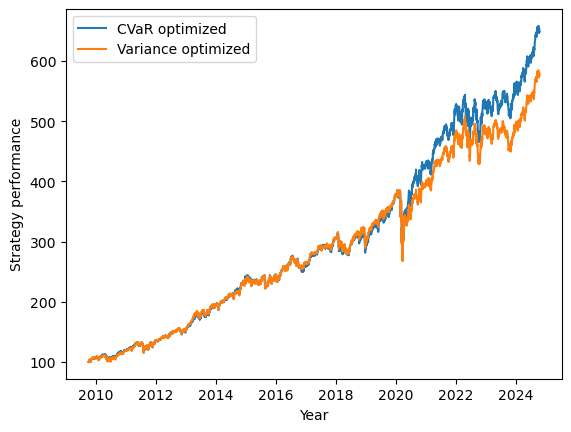

In [196]:
plt.plot(data.iloc[-out_of_sample_obs:].index, performance_cvar)
plt.plot(data.iloc[-out_of_sample_obs:].index, performance_variance)
plt.legend(['CVaR optimized', 'Variance optimized'])
plt.xlabel('Year')
plt.ylabel('Strategy performance')
plt.show()

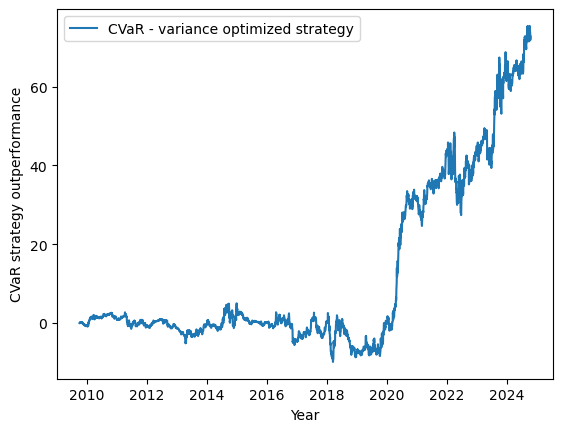

In [197]:
plt.plot(data.iloc[-out_of_sample_obs:].index, performance_cvar - performance_variance)
plt.legend(['CVaR - variance optimized strategy'])
plt.xlabel('Year')
plt.ylabel('CVaR strategy outperformance')
plt.show()

# Synthetic performance

In [222]:
oos_synth_paths[:, 0, :] = 0.
prices_synth = 100 * np.exp(np.cumsum(oos_synth_paths, axis=1))

In [234]:
performance_cvar_synth = np.full((S_oos_synth, out_of_sample_obs), np.nan)
performance_cvar_synth[:, 0] = 100
performance_variance_synth = np.full((S_oos_synth, out_of_sample_obs), np.nan)
performance_variance_synth[:, 0] = 100

for s in np.arange(S_oos_synth):
    prices_synth_run = prices_synth[s]
    for q in np.arange(out_of_sample_quarters):
        holding_cvar = performance_cvar_synth[s, q * H] * cvar_results[:, q] / prices_synth_run[q * H, :]
        performance_cvar_synth[s, 1+q * H:(q + 1) * H + 1] = prices_synth_run[1+q * H:(q + 1) * H + 1, :] @ holding_cvar

        holding_variance = performance_variance_synth[s, q * H] * variance_results[:, q] / prices_synth_run[q * H, :]
        performance_variance_synth[s, 1+q * H:(q + 1) * H + 1] = prices_synth_run[1+q * H:(q + 1) * H + 1, :] @ holding_variance

<Axes: ylabel='Count'>

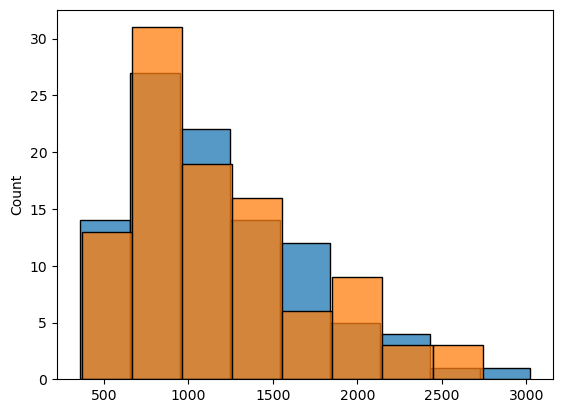

In [246]:
import seaborn as sns
sns.histplot(performance_cvar_synth[:, -1])
sns.histplot(performance_variance_synth[:, -1])